# Anomaly detection with OCSVM

The One-Class SVM is a modified support vector machine model that is well-suited for novelty detection (an example of semi-supervised anomaly detection). 
The idea is that the model trains on normal data and is used to detect anomalies when new data is presented to it. While the OC-SVM might seem best suited to semi-supervised anomaly detection, since training on only one class means it’s still “partially labeled” when considering the entire data set, it can also be used for unsupervised anomaly detection.

Similar to the isolation forest, the OC-SVM is also good for high-dimensional data. 

During training, the OC-SVM learns the decision boundary for normal observations, accounting for a few outliers. If novelties, new data points that the model has never seen before, fall within this decision boundary, they are considered normal by the model.

If they fall outside of the boundary, they are considered anomalous. This technique is an example of semi-supervised novelty detection, where the goal is to train the model on normal data, and then it attempts to find anomalies in new data.

# Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import OneClassSVM

In [40]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe,scoring,fe

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [12]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv(f"E:/gitlab/machine-learning/dataset/kddcup.data.corrected", sep=",", names=columns, index_col=None)

In [5]:
describe.describe_data(df)

'table size 4898431 x 42'

Dataframe has 42 columns.
There are 0 columns that have missing values.


,column_names,Data Type,Missing Values,% missing,low Value,Hi Value,stddev Value,unique
0,duration,int64,0,0.0,0,58329,723,9883.0
1,protocol_type,object,0,0.0,0,0,0,3.0
2,service,object,0,0.0,0,0,0,70.0
3,flag,object,0,0.0,0,0,0,11.0
4,src_bytes,int64,0,0.0,0,1379963888,941431,7195.0
5,dst_bytes,int64,0,0.0,0,1309937401,645012,21493.0
6,land,int64,0,0.0,0,1,0,2.0
7,wrong_fragment,int64,0,0.0,0,3,0,3.0
8,urgent,int64,0,0.0,0,14,0,6.0
9,hot,int64,0,0.0,0,77,0,30.0


# Feature engineering

In [13]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
columns.remove("service")

In [14]:
novelties = df[df["label"] != "normal."]
novelties_normal = df[150000:154045]

novelties = pd.concat([novelties, novelties_normal])
normal = df[df["label"] == "normal."]

In [15]:
print(novelties.shape)
print(normal.shape)

(8090, 41)
(619046, 41)


In [16]:
novelties.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
226685,0,tcp,S0,0,0,0,0,0,0,0,...,1,0.00,0.31,0.53,0.00,0.01,1.00,0.52,0.00,portsweep.
226686,0,tcp,S0,0,0,0,0,0,0,0,...,2,0.01,0.31,0.53,0.00,0.02,1.00,0.52,0.00,portsweep.
226687,1,tcp,RSTOS0,1,0,0,0,0,0,0,...,3,0.01,0.31,0.53,0.00,0.02,0.67,0.52,0.33,portsweep.
263531,0,tcp,REJ,0,0,0,0,0,0,0,...,194,0.02,1.00,0.02,0.04,0.00,0.00,0.93,0.01,ipsweep.
263734,0,tcp,REJ,0,0,0,0,0,0,0,...,2,0.02,1.00,0.02,1.00,0.00,0.00,0.92,1.00,ipsweep.


In [17]:
novelties.tail(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
209742,0,tcp,SF,216,2431,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.
209743,0,tcp,SF,218,8746,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.
209744,0,tcp,SF,144,9534,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.
209745,0,tcp,SF,244,250,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.
209746,0,tcp,SF,205,12625,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.


In [18]:
for col in normal.columns:
    if normal[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(normal[col])
        normal[col] = encoded.transform(normal[col])
        
for col in novelties.columns:
    if novelties[col].dtype == "object":
        encoded2 = LabelEncoder()
        encoded2.fit(novelties[col])
        novelties[col] = encoded2.transform(novelties[col])

In [19]:
novelties.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
226685,0,0,3,0,0,0,0,0,0,0,...,1,0.00,0.31,0.53,0.00,0.01,1.00,0.52,0.00,6
226686,0,0,3,0,0,0,0,0,0,0,...,2,0.01,0.31,0.53,0.00,0.02,1.00,0.52,0.00,6
226687,1,0,1,1,0,0,0,0,0,0,...,3,0.01,0.31,0.53,0.00,0.02,0.67,0.52,0.33,6
263531,0,0,0,0,0,0,0,0,0,0,...,194,0.02,1.00,0.02,0.04,0.00,0.00,0.93,0.01,1
263734,0,0,0,0,0,0,0,0,0,0,...,2,0.02,1.00,0.02,1.00,0.00,0.00,0.92,1.00,1


In [20]:
novelties.tail(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
209742,0,0,6,216,2431,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4
209743,0,0,6,218,8746,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4
209744,0,0,6,144,9534,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4
209745,0,0,6,244,250,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4
209746,0,0,6,205,12625,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4


 # suffle and split

In [21]:
for f in range(0, 10):
    normal = normal.iloc[np.random.permutation(len(normal))]
    
df2 = pd.concat([normal[:100000],normal[200000:250000]])
df_validate = normal[100000:150000]
x_train, x_test= train_test_split(df2, test_size = 0.2, random_state = 42)
x_val = df_validate

In [22]:
print("Shapes:\nx_train:{}\n" .format(x_train.shape))
print("x_test:{}\n".format (x_test.shape))
print("x_val:{}\n".format (x_val.shape))

Shapes:
x_train:(120000, 41)

x_test:(30000, 41)

x_val:(50000, 41)



# Model

In [24]:
ocsvm = OneClassSVM(kernel='rbf', gamma=0.00005, nu=0.1)

In [25]:
ocsvm.fit(x_train)

OneClassSVM(gamma=5e-05, nu=0.1)

In [26]:
x_test['label'].value_counts()

0    30000
Name: label, dtype: int64

the kernel is set to ‘rbf’, meaning radial basis function. It is similar to the circular decision boundary that you saw in the earlier examples, and you use it here because you want to define a circular boundary around a set of regions that contain normal data.

Gamma tells the model how much you want to consider points further from the hyperplane. Since it is pretty small, this means you want to emphasize the points farther away.

nu specifies how much of the training set contains outliers. Again, you set this to 0.1, similar to the isolation forest model.

you can still measure the accuracy of the model on the test and validation
sets. Even though accuracy is not the best metric to go by, it can still give you a good indicator of the model’s performance

Accuracy in this case is a measure of the percentage of data points in the predictions that are normal data points. Remember, you assumed that around 10% of the data points in the data set are anomalies, so the most optimal “accuracy” to obtain is 90%.

# measurement

In [27]:
preds = ocsvm.predict(x_test)
score = 0
for f in range(0, x_test.shape[0]):
    if(preds[f] == 1):
        score = score + 1

accuracy = score / x_test.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.65%


In [28]:
preds = ocsvm.predict(x_val)
score = 0
for f in range(0, x_val.shape[0]):
    if(preds[f] == 1):
        score = score + 1
        
accuracy = score / x_val.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.51%


# AUC

Now to test on the novelties data set. This time, you can find the AUC score because there is a 50-50 split between anomalies and normal data. The other two data sets, x_test and x_validation, only had normal data, but this time it is possible for the model to classify false positives and true negatives.

In [33]:
from sklearn.metrics import roc_auc_score

preds = ocsvm.predict(novelties)
matches = novelties["label"] == 4

auc = roc_auc_score(preds, matches)
print("AUC: {:.2%}".format (auc))

AUC: 95.86%


## the distribution of predictions

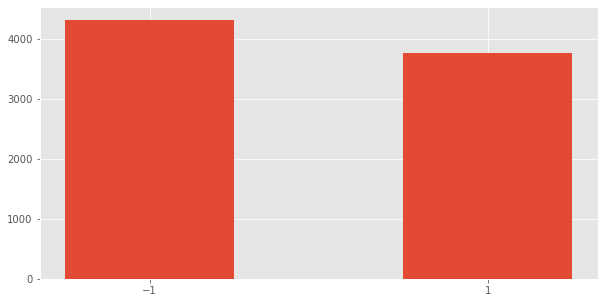

In [34]:
plt.figure(figsize=(10,5))
plt.hist(preds, bins=[-1.5, -0.5] + [0.5, 1.5], align='mid')
plt.xticks([-1, 1])
plt.show()

In [53]:
predss = pd.DataFrame(preds,columns=['res'])

In [64]:
key = [[0,1]]

In [70]:
preds_true,dic = fe.mapping(predss,['res'],'def',key)

comfusion matrix = 
[[4005   40]
 [ 312 3733]]

accuracy_score =  0.9565
balanced_accuracy_score =  0.9565

precision score =  0.9894
average precision score =  0.9516
recall score =  0.9229

F1 score =  0.955
F2 score =  0.9753
F3 score =  0.9823
F_beta score =  0.9823
Matthews Correlation Coefficient score =  0.9151

AUC of Precision-Recall Curve on Testing =  0.9754
Best Threshold for Precision-Recall Curve = 1.000000
F-Score = 0.955
AUC of ROC =  0.9565

Best Threshold for ROC = 1.000000
G-Mean = 0.956
Best Threshold with Youden’s J statistic = 1.000000

Cohens kappa =  0.913
Gini =  0.9508

Expected Approval Rate =  0.4664
Expected Default Rate =  0.0106

classification_report
              precision    recall  f1-score   support

       False       0.93      0.99      0.96      4045
        True       0.99      0.92      0.95      4045

    accuracy                           0.96      8090
   macro avg       0.96      0.96      0.96      8090
weighted avg       0.96      0.96    

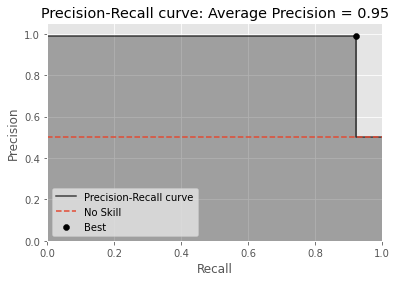

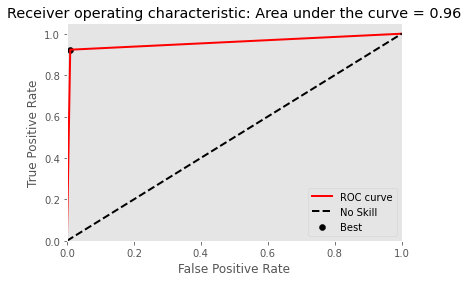


time span=  1


In [72]:
scoring.print_score(matches,preds_true,preds_true)